# LFVI for HDDM

Suppose we have a subject-level data generating distribution $p(x\mid z,\beta)$ where $z$ is a "local" latent varaible, and $\beta$ is a "global" latent variable (i.e. a hyperparameter in a hierarchical setting). For example, $z$ could be a subject-specific DDM parameter, and $\beta$ could be the the group mean / variance etc. We are interested in the setting where this likelihood is intractable, i.e. has no "cheap" closed-form expression. We assume that we do however have a fast simulator for drawing samples $x \sim p(x\mid z, \beta)$. 

What we actually want for our typical application is $p(\beta\mid x)$, i.e. the marginal posterior of the population hyperparameters. As we know from Gelman, we can find the marginal posterior mode by EM or other variational methods. First, we derive our variational objective. This is pretty much straight out of Gelman's BDA. First, use law of conditional probability: 

$$
\log p(\beta \mid x) = \log p(\beta, z \mid x) - \log p(z \mid \beta, x)
$$

Next, introduce the variational posterior $q(z \mid \beta, x)$ summing to 0

$$
\log p(\beta \mid x) = \log p(\beta, z \mid x) - \log p(z \mid \beta, x)+ q(z \mid \beta, x)- q(z \mid \beta, x)
$$

Now take expectation with respect to the variational posterior. Since the LHS is independent of $z$, immediately drop the expectation on the LHS: 

$$
\log p(\beta \mid x) = \mathbb{E}_{q(z \mid \beta, x)}\log p(\beta, z \mid x) - \mathbb{E}_{q(z \mid \beta, x)}\log p(z \mid \beta, x)+ \mathbb{E}_{q(z \mid \beta, x)} q(z \mid \beta, x)- \mathbb{E}_{q(z \mid \beta, x)}q(z \mid \beta, x)
$$

Recognize that we now have a KL divergence, so collect it: 

$$
\log p(\beta \mid x) = \mathbb{E}_{q(z \mid \beta, x)}\log p(\beta, z \mid x) - \mathbb{E}_{q(z \mid \beta, x)} q(z \mid \beta, x)- \mathcal{D}_{KL}(q(z \mid \beta, x)||p(z \mid \beta, x))
$$

What we ended up with is the expected log joint posterior, the enrtopy of the variational posterior, and the KL divergence between the true and variational posterior. The entropy of the variational posterior is constant, and the KL term goes to 0 as the variational posterior approaches the true posterior. That is: by maximizing the first term, we maximize a lower bound on the posterior mode. The first two terms together are sometimes called the evidence lower bound or ELBO, which we expand and expand by Bayes' rule: 

$$
\begin{aligned}
\mathcal{L} &= \mathbb{E}_{q(z \mid \beta, x)}\log p(\beta, z \mid x) - \mathbb{E}_{q(z \mid \beta, x)} q(z \mid \beta, x)\\
&= \mathbb{E}_{q(z \mid \beta, x)}\log p(x \mid \beta, z) - \mathbb{E}_{q(z \mid \beta, x)}\log p(\beta, z)-  \mathbb{E}_{q(z \mid \beta, x)}\log p(x)- \mathbb{E}_{q(z \mid \beta, x)} q(z \mid \beta, x)
\end{aligned}
$$

The last term is the normalization constant for Bayes' rule, so we don't need to worry about it for optimizing the ELBO. The second term is the expected log prior, and is also fine (at worst, we could use monte carlo expectation). But the first term, as mentioned above, has no tractable explicit likelihood. 

What we will do here is use a differentiable ratio estimator to get around the problem. The idea is directly taken from Tran et al. 2017 but we use it slightly differently because (a) we want a posterior marginal rather than marginal likelihood (that just means we add a prior), and (b) we exploit the fact that the conditional distribution $p(z\mid \beta)$ is nice in the hierarchical regression setting. First, we introduce a variational empirical density $\mathbb{E}_{q(z \mid \beta, x)} q(x)$: 

$$
\mathcal{L} =\mathbb{E}_{q(z \mid \beta, x)}\log p(x \mid z, \beta) + \mathbb{E}_{q(z \mid \beta, x)}\log p(z, \beta)-  \mathbb{E}_{q(z \mid \beta, x)}\log p(x) - \mathbb{E}_{q(z \mid \beta, x)} q(z \mid \beta, x)-\mathbb{E}_{q(z \mid\beta, x)} q(x)+\mathbb{E}_{q(z \mid \beta, x)} q(x)
$$

We use that to collect and rearrange: 

$$
\begin{aligned}
\mathcal{L} =&\mathbb{E}_{q(z \mid \beta, x)}\log p(x \mid z, \beta) + \mathbb{E}_{q(z \mid \beta, x)}\log p(z, \beta)-  \mathbb{E}_{q(z \mid \beta, x)}\log p(x) - \mathbb{E}_{q(z \mid \beta, x)} q(x, z \mid \beta)+\mathbb{E}_{q(z \mid \beta, x)} q(x)\\
=& \mathbb{E}_{q(z \mid \beta, x)}\log p(x \mid z, \beta) + \mathbb{E}_{q(z \mid \beta, x)}\log p(z, \beta)-  \mathbb{E}_{q(z \mid \beta, x)}\log p(x)\\
&- \mathbb{E}_{q(z \mid \beta, x)}\log q(x \mid z,\beta)-  \mathbb{E}_{q(z \mid \beta, x)}\log q(z \mid \beta)+\mathbb{E}_{q(z \mid \beta, x)} q(x)\\
=& \mathbb{E}_{q(z \mid \beta, x)}\log p(x \mid z, \beta) + \mathbb{E}_{q(z \mid \beta, x)}\log p(z \mid \beta)+ \mathbb{E}_{q(z \mid \beta, x)}\log p( \beta)-  \mathbb{E}_{q(z \mid \beta, x)}\log p(x)\\
&- \mathbb{E}_{q(z \mid \beta, x)}\log q(x \mid z,\beta)-  \mathbb{E}_{q(z \mid \beta, x)}\log q(z \mid \beta)+\mathbb{E}_{q(z \mid \beta, x)} q(x)
\end{aligned}
$$

This is just a prior plus a sum of density ratios: 

$$
\mathcal{L} =\mathbb{E}_{q(z \mid \beta, x)}\log \frac{p(x \mid z, \beta)}{q(x \mid z, \beta)} + \mathbb{E}_{q(z \mid \beta, x)}\log \frac{p(z \mid \beta)}{q(z \mid \beta)}-  \mathbb{E}_{q(z \mid \beta, x)}\log\frac{p(x)}{q(x)}+\mathbb{E}_{q(z \mid \beta, x)}\log p( \beta)
$$

Here is where we diverge from the LFVI paper a little. In their case, they combine our first two terms, and use a differentiable density estimator for that density. This does not require them to pick a variational $q(z\mid \beta)$. For our case, we make both $q(z\mid \beta)$ and $q(z\mid \beta)$ multivariate Gaussian (with $q$ parameterized by $\beta'$). We make $q(z\mid\beta,x)$ a gaussian with mean and (diagonal) variance functions modeled by neural networks (this is the usual VAE trick, and we do the usual reparameterization here). We import the ratio estimation trick wholesale from Tran et al.: the basic idea is that if we train a classifier to discriminate between the simulator $p(x\mid z, \beta)$ and the surrogate simulator $q(x\mid z, \beta)$, the ratio of the predicted class assignments approximates the ratio of densities. To find this ratio estimator, we minimize the following loss or any other proper scoring rule: 

$$
\mathcal{D}_{\log} = \mathbb{E}_{p(x\mid z, \beta)}\left[-\log\sigma (r(x, z, \beta; \theta))\right] + \mathbb{E}_{q(x\mid z, \beta)}\left[-\log\sigma(1- r(x, z, \beta; \theta))\right]
$$

We minimize this in the parameters $\theta$ of anoher neural network function $r(\cdot)$. Next, we plug in the real $x$ to evaluate the ratio as part of the rest of the ELBO, which we minimize in the other parameters. Now we implement. 

In [1]:
# support functions

import tensorflow as tf
from tensorflow.contrib.distributions import MultivariateNormalTriL, MultivariateNormalDiag, Normal, kl_divergence
from scipy.stats import norm
import numpy as np

def _dense_mlp_layer(x, input_size, out_size, nonlinearity=tf.nn.softmax, name_prefix=""):
    """ One MLP layer. Can probably be replaced with keras..."""
    # if x is a tensorflow object, apply to only this object
    w_init = tf.truncated_normal(shape=[out_size, input_size], stddev=0.001, dtype=global_dtype)
    b_init = tf.ones(shape=[out_size, 1]) * 0.1
    W = tf.Variable(w_init, name="%s_W" % name_prefix, dtype=global_dtype)
    b = tf.Variable(b_init, name="%s_b" % name_prefix, dtype=global_dtype)
    if isinstance(x, tf.Variable) or isinstance(x, tf.Tensor):
        out = nonlinearity(tf.matmul(W, x) + b)
    else: # otherwise if it is iterable apply to all 
        out = [nonlinearity(tf.matmul(W, x_) + b) for x_ in x]
    return out, [W, b]

def _mlp(x, input_size, n_layers, units_per_layer, out_size, nonlinearity=tf.tanh, batch_size=None):
    """ A feedforward net. Can probably be replaced with keras..."""
    train_vars = []
    x, v = _dense_mlp_layer(x, input_size, units_per_layer, nonlinearity, name_prefix="into_hidden")
    train_vars.extend(v)
    # exploit the fact that repeatedly calling the same TF function creates multiple ops. 
    # no need to hang onto the intermediate layer handles (though we can get them back if we need them)
    for l in range(n_layers-1):
        x, v = _dense_mlp_layer(x, units_per_layer, units_per_layer, nonlinearity, name_prefix="hidden")
        train_vars.extend(v)

    x, v = _dense_mlp_layer(x, units_per_layer, out_size, nonlinearity, name_prefix="readout")
    train_vars.extend(v)
    return x, train_vars

def _reparam_nnet_gaussian(inp, out_size, nnet_conf):
    """Gaussian parameterized by mean and covariance nets, with reparameterization trick """
    q_network, q_vars = _mlp(inp, **nnet_conf)
    # now map from this net to params of a gaussian
    # weigts
    w_mu = tf.Variable(tf.truncated_normal(shape=[out_size, nnet_conf['out_size']], stddev=0.1), name="w_mu")
    w_logsig = tf.Variable(tf.truncated_normal(shape=[out_size, nnet_conf['out_size']], stddev=0.1), name="w_logsig")
    # biases
    b_mu = tf.Variable(tf.truncated_normal(shape=[out_size, 1], stddev=0.1), name="b_mu")
    b_logsig = tf.Variable(tf.truncated_normal(shape=[out_size, 1], stddev=0.1), name="b_logsig")
    # mean and var
    epsilon = tf.random_normal([out_size, 1])

    if isinstance(q_network, tf.Variable) or isinstance(q_network, tf.Tensor):
        q_mu = tf.matmul(w_mu, q_network) + b_mu
        q_logsigma = tf.matmul(w_logsig, q_network) + b_logsig
        # draw a sample
        x = q_mu + tf.sqrt(tf.exp(q_logsigma)) * epsilon

    else: # otherwise if it is iterable apply to all 
        q_mu = [tf.matmul(w_mu, q) + b_mu for q in q_network]
        q_logsigma = [tf.matmul(w_logsig, q) + b_logsig for q in q_network]
        # draw a sample
        x = [mu + tf.sqrt(tf.exp(logsigma)) * epsilon for mu, logsigma in zip(q_mu, q_logsigma)]

    return x, [*q_vars, w_mu, w_logsig, b_mu, b_logsig]

/Users/ms44/anaconda/envs/tf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# synth data and config
tf.set_random_seed(1)
beta_mu = 15
beta_var = 10
subj_var = 1

beta_size = 2 # mean, var
z_size = 1
n_subj = 20
obs_per_subj = 100

# trivial subjectwise simulator
def psim(subj_var, z):
    return norm.rvs(loc=z, scale=subj_var, size=[obs_per_subj, 1])

# now zs are each subject's mean
z_data = norm.rvs(loc=beta_mu, scale=beta_var, size=n_subj)
x_data = np.array([psim(subj_var, zs) for zs in z_data])

In [3]:
# configurations of nets

# network of (x|z,beta)
qsim_config = {'input_size': beta_size + z_size,
                'n_layers': 1,
               'units_per_layer': 50,
               'out_size': 50,
               'nonlinearity': tf.sigmoid}

# network for ratio estimation
r_config = {'input_size': beta_size + z_size +obs_per_subj,
                'n_layers': 1,
               'units_per_layer': 50,
               'out_size': 50,
               'nonlinearity': tf.sigmoid}

# network for q(z|x,beta)
qz_config = {'input_size': beta_size + obs_per_subj,
                'n_layers': 1,
               'units_per_layer': 50,
               'out_size': 50,
               'nonlinearity': tf.sigmoid}

In [4]:
# variables and placeholders
global_dtype = tf.float32

beta = tf.Variable(tf.random_normal(shape=[beta_size, 1]), dtype=global_dtype, name='beta')

# x is a placeholder for a single subject's data
x_ph = tf.placeholder(shape=[obs_per_subj, 1], dtype=global_dtype, name='x_ph')

In [5]:
# ops constructing all the nets
def qz_op(x_ph, beta, qz_config):
    """qz takes in x and beta and returns z:  z ~ q(z | x, beta)
    """
    return _reparam_nnet_gaussian(tf.concat([x_ph, beta], 0), z_size, qz_config)

def qsim_op(z, beta, qsim_config):
    """qsim takes in z and beta and returns x:  x ~ q(x | z, beta)
        x dimensionality should be batch_size by obs_per_subj
    """
    # zconcat = [tf.concat([z_, beta], 0) for z_ in z]
    return _reparam_nnet_gaussian(tf.concat([z, beta], 0), obs_per_subj, qsim_config)


def r_op(x_p, x_q, z, beta, r_config):
    """ Takes in x,z,beta returns r(x, z, beta)
    """
    # we use the same r for all subjects and also for both x_p and x_q... 
    xp_concat = tf.concat([x_p, z, beta], 0)
    xq_concat = tf.concat([x_q, z, beta], 0)
    [r_p, r_q], r_vars = _mlp([xp_concat, xq_concat], **r_config)
    
    # # now readout into scalar
    W = tf.Variable(tf.truncated_normal(shape=[1, r_config['units_per_layer']], stddev=0.001, dtype=global_dtype), name="r_w", dtype=global_dtype)
    b = tf.Variable(tf.ones(shape=[1]) * 0.1, name="r_b", dtype=global_dtype)
    r_vars.extend([W, b])

    r_p = r_config['nonlinearity'](tf.matmul(W, r_p) + b)
    r_q = r_config['nonlinearity'](tf.matmul(W, r_q) + b)

    return r_p, r_q, r_vars


In [6]:
# construct the nets 
z, qz_vars = qz_op(x_ph, beta, qz_config)
x_qsim, qsim_vars = qsim_op(z, beta, qsim_config) 
r_p, r_q, r_vars = r_op(x_ph, x_qsim, z, beta, r_config)

# p(z|beta) is normal
p_z = Normal(loc=beta[0], scale=tf.exp(beta[1]))

# q(z|beta) is  normal p(z|beta') like in EM
betaprime = tf.Variable(tf.random_normal(shape=[beta_size, 1]), dtype=global_dtype, name='betaprime')
q_z = Normal(loc = betaprime[0], scale = tf.exp(betaprime[1]))

In [7]:
# ratio loss (cross-entropy)
ratio_est_loss = tf.reduce_sum(-tf.log(tf.sigmoid(1e-5 + r_p)) - tf.log(tf.sigmoid(1e-5 + 1-r_q)))

# optimizer steps: 
opt = tf.train.AdamOptimizer(0.005)
ratio_est_step = opt.minimize(ratio_est_loss, var_list = [r_vars])

step 0: ratio loss=18.965961
step 50: ratio loss=12.876749
step 100: ratio loss=12.862408
step 150: ratio loss=13.644281
step 200: ratio loss=12.557902
step 250: ratio loss=13.302330


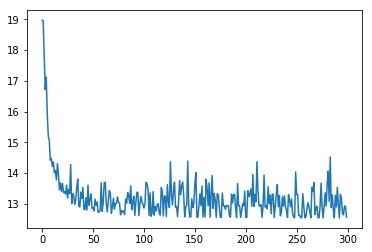

In [8]:
# try ratio estimator alone, does it optimize? 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_steps = 300
ratio_loss_log = np.zeros(train_steps)

for i in range(train_steps):
    # fix a single z for each update, else the stochastic grad is not valid
    z_current = [z.eval(session=sess, feed_dict={x_ph:x_}) for x_ in x_data]
    x_p = [psim(subj_var, z_) for z_ in z_current]
    
    ratio_loss_log[i] = np.sum([ratio_est_loss.eval(session=sess, feed_dict={z:z_, x_ph:x_}) for (z_,x_) in  zip(z_current, x_p)])

    # step ratio for each subject
    for j in range(n_subj):
        sess.run(ratio_est_step, feed_dict={x_ph: x_p[j], z:z_current[j]})
    if i % 50 == 0:
        print("step %i: ratio loss=%f" %(i, ratio_loss_log[i]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ratio_loss_log) # looks okay 

step 0: ELBO=867.199646, beta_mu=-0.615616, beta_var=1.199771, bp_mu=2.460016, bp_var=0.266627
step 10: ELBO=46284104.000000, beta_mu=-1.746057, beta_var=5.623719, bp_mu=4.534705, bp_var=0.030391
step 20: ELBO=317449732096.000000, beta_mu=-1.845168, beta_var=17.283634, bp_mu=7.906955, bp_var=0.000957
step 30: ELBO=5133453360103424.000000, beta_mu=-1.873330, beta_var=37.962246, bp_mu=12.161045, bp_var=0.000013
step 40: ELBO=nan, beta_mu=nan, beta_var=nan, bp_mu=nan, bp_var=nan
step 50: ELBO=nan, beta_mu=nan, beta_var=nan, bp_mu=nan, bp_var=nan
step 60: ELBO=nan, beta_mu=nan, beta_var=nan, bp_mu=nan, bp_var=nan
step 70: ELBO=nan, beta_mu=nan, beta_var=nan, bp_mu=nan, bp_var=nan
step 80: ELBO=nan, beta_mu=nan, beta_var=nan, bp_mu=nan, bp_var=nan
step 90: ELBO=nan, beta_mu=nan, beta_var=nan, bp_mu=nan, bp_var=nan


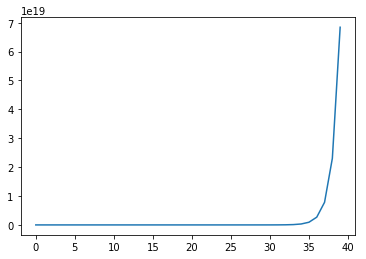

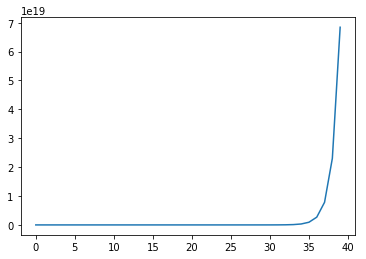

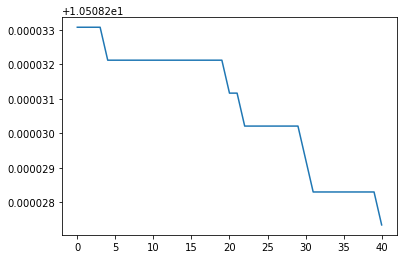

In [14]:
# elbo: p(z|beta) - q(z|beta) + r*(x,z,beta), everything factors by subject
kl = p_z.log_prob(z) - q_z.log_prob(z)
# kl = kl_divergence(q_z, p_z)
# elbo =  kl + r_p
elbo =  r_p + kl

elbo_step = opt.minimize(-elbo, var_list=[qsim_vars, qz_vars, beta, betaprime])

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_steps = 100
elbo_log = np.zeros(train_steps)
r_p_log = np.zeros(train_steps)
kl_log = np.zeros(train_steps)

# oldbeta = beta.eval(session=sess)
for i in range(train_steps):
    
    # record elbo etc before step
    elbo_log[i] = np.sum([elbo.eval(session=sess, feed_dict={x_ph:x_, z:z_}) for x_,z_ in zip(x_data, z_current)])
#     kl_log[i] = np.sum([kl.eval(session=sess, feed_dict={x_ph:x_, z:z_, betaprime:oldbeta}) for x_,z_ in zip(x_data, z_current)])
    kl_log[i] = np.sum([kl.eval(session=sess, feed_dict={x_ph:x_, z:z_}) for x_,z_ in zip(x_data, z_current)])
    r_p_log[i] = np.sum([r_p.eval(session=sess, feed_dict={x_ph:x_, z:z_}) for x_,z_ in zip(x_data, z_current)])

    # fix a z for this step
    z_current = [z.eval(session=sess, feed_dict={x_ph:x_}) for x_ in x_data]
    # M-step on the z|beta KL ? 
#     oldbeta = beta.eval(session=sess)

    # step elbo for each subject
    for j in range(n_subj):
        sess.run(elbo_step, feed_dict={x_ph: x_data[j], z:z_current[j]})
    

    if i % 10 == 0:
        beta_hat = beta.eval(session=sess)
        betaprime_hat = betaprime.eval(session=sess)
        print("step %i: ELBO=%f, beta_mu=%f, beta_var=%f, bp_mu=%f, bp_var=%f" %
              (i, elbo_log[i], beta_hat[0], np.exp(beta_hat[1]), betaprime_hat[0], np.exp(betaprime_hat[1])))
        
plt.plot(elbo_log) # ELBO explodes
plt.figure()
plt.plot(kl_log) 
plt.figure()
plt.plot(r_p_log) 

# also KL and r() don't even add to ELBO? 

In [11]:
# optimize together, everything is worse... 

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_steps = 1000
ratio_loss_log = np.zeros(train_steps)
elbo_log = np.zeros(train_steps)
r_p_log = np.zeros(train_steps)
kl_log = np.zeros(train_steps)

for i in range(train_steps):

    # record elbo etc before step
    elbo_log[i] = np.sum([elbo.eval(session=sess, feed_dict={x_ph:x_, z:z_}) for x_,z_ in zip(x_data, z_current)])
    kl_log[i] = np.sum([kl.eval(session=sess, feed_dict={x_ph:x_, z:z_, betaprime:oldbeta}) for x_,z_ in zip(x_data, z_current)])
    r_p_log[i] = np.sum([r_p.eval(session=sess, feed_dict={x_ph:x_, z:z_}) for x_,z_ in zip(x_data, z_current)])
    ratio_loss_log[i] = np.sum([ratio_est_loss.eval(session=sess, feed_dict={z:z_, x_ph:x_}) for (z_,x_) in  zip(z_current, x_p)])
    
    # fix a z for this step
    z_current = [z.eval(session=sess, feed_dict={x_ph:x_}) for x_ in x_data]
    # M-step on the z|beta KL ? 
    oldbeta = beta.eval(session=sess)

    # step elbo for each subject
    for j in range(n_subj):
        sess.run(elbo_step, feed_dict={x_ph: x_data[j], z:z_current[j]})
    


    #  step ratio for each subject
    for k in range(20):
        x_p = [psim(subj_var, z_) for z_ in z_current]
        for j in range(n_subj):
            sess.run(ratio_est_step, feed_dict={x_ph: x_p[j], z:z_current[j]})

    if i % 50 == 0:
        beta_hat = beta.eval(session=sess)
        print("step %i: ratio loss=%f, ELBO=%f, beta_mu=%f, beta_var=%f" %
              (i, ratio_loss_log[i], elbo_log[i], beta_hat[0], np.exp(beta_hat[1])))


step 0: ratio loss=nan, ELBO=nan, beta_mu=-0.728820, beta_var=1.308095


KeyboardInterrupt: 

In [ ]:
plt.plot(ratio_loss_log) # nice and smooth
plt.figure()
plt.plot(elbo_log) # explodes